COMPREHENSIVE POLY-SI THICKNESS OPTIMIZATION ANALYSIS

Research Objectives:
• Find optimal Poly-Si thickness for maximum performance
• Analyze S-parameters (S11, S21) vs thickness
• Study conductivity behavior in Poly-Si region
• Minimize scattering losses and total losses
• Consider frequency and voltage dependence
Finding optimal Poly-Si thickness...
Optimal Poly-Si thickness: 1207.70 nm
Best performance score: 0.398

1. OPTIMIZATION ANALYSIS


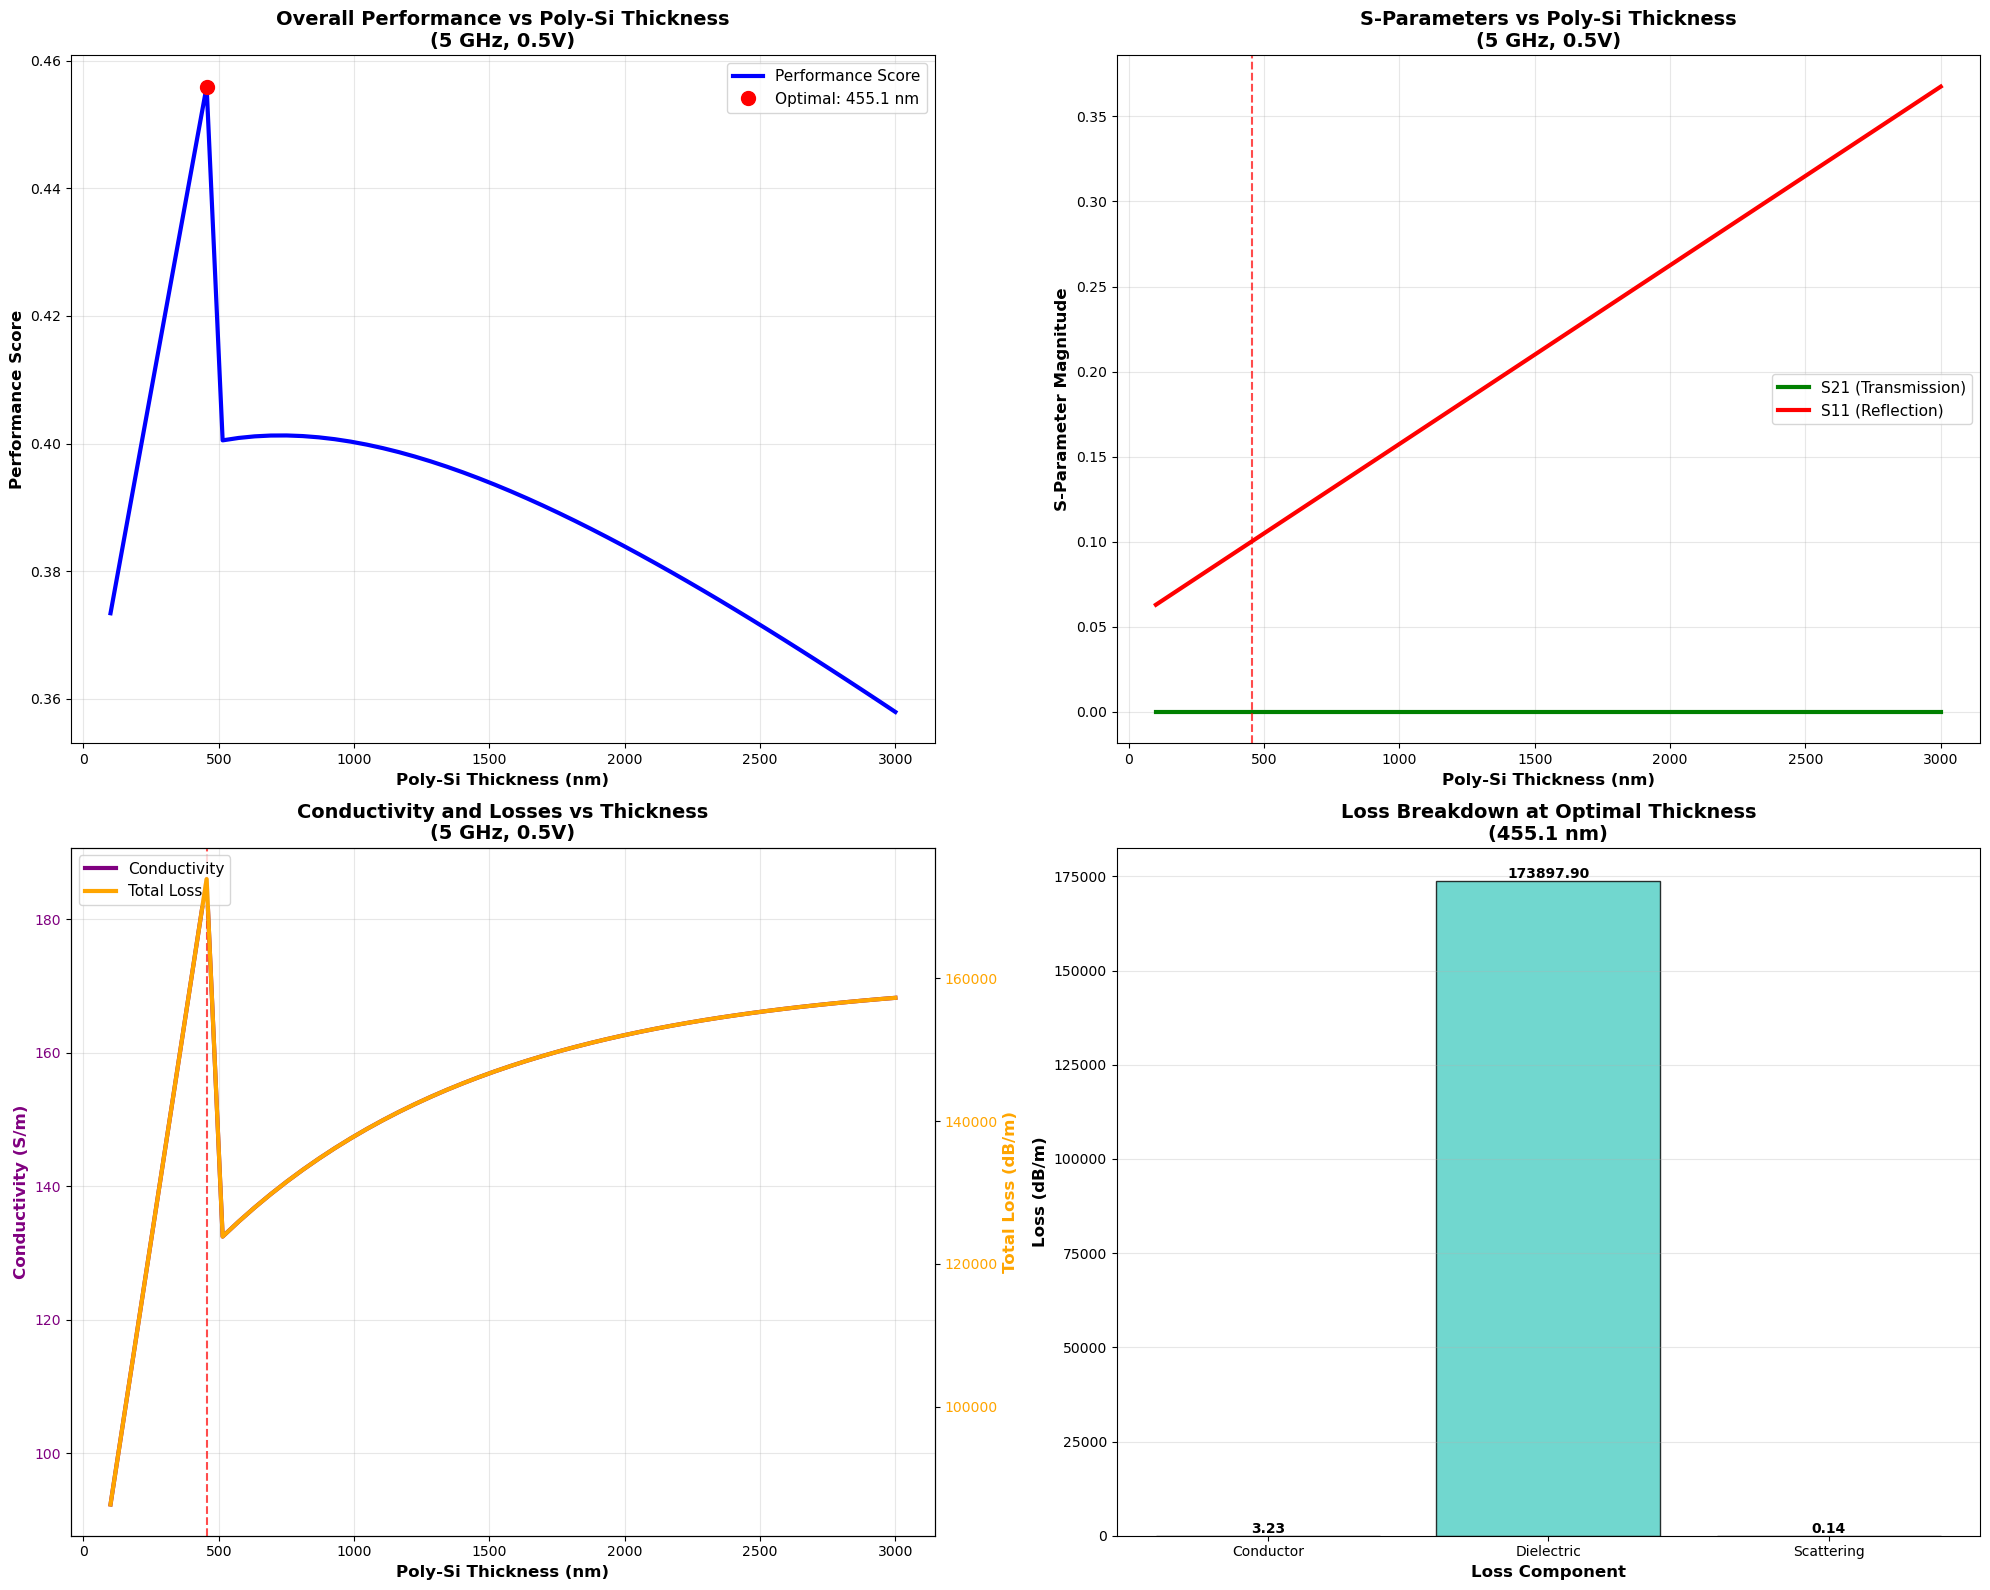


2. FREQUENCY DEPENDENCE ANALYSIS


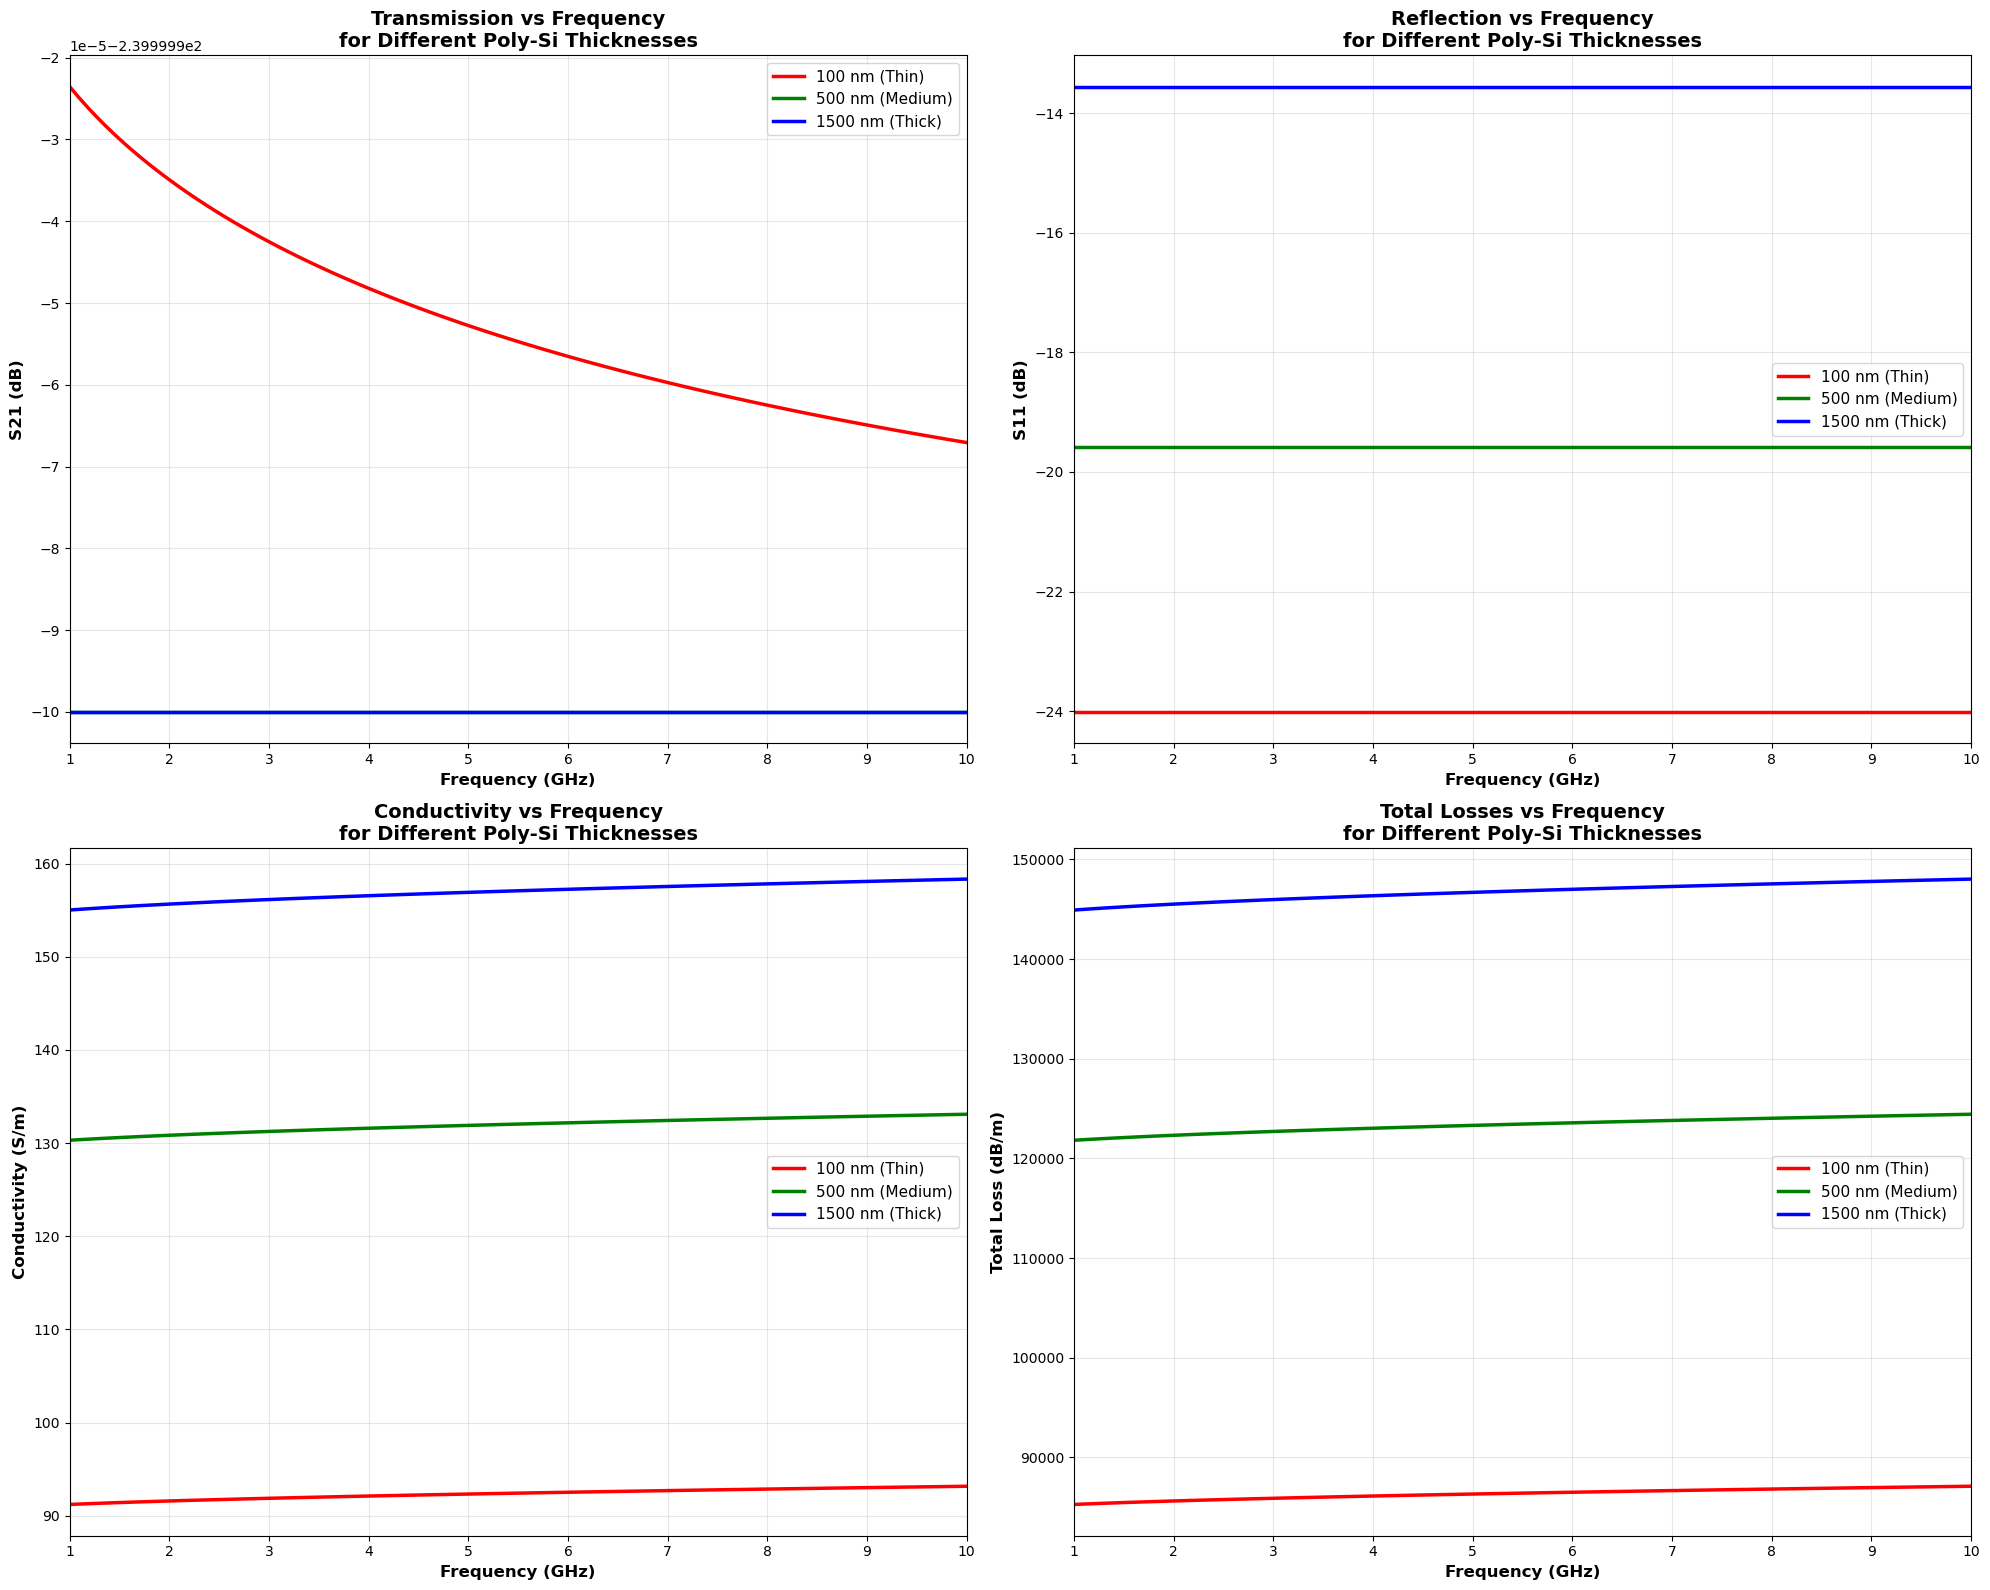


3. VOLTAGE DEPENDENCE ANALYSIS
Finding optimal Poly-Si thickness...
Optimal Poly-Si thickness: 1207.70 nm
Best performance score: 0.398


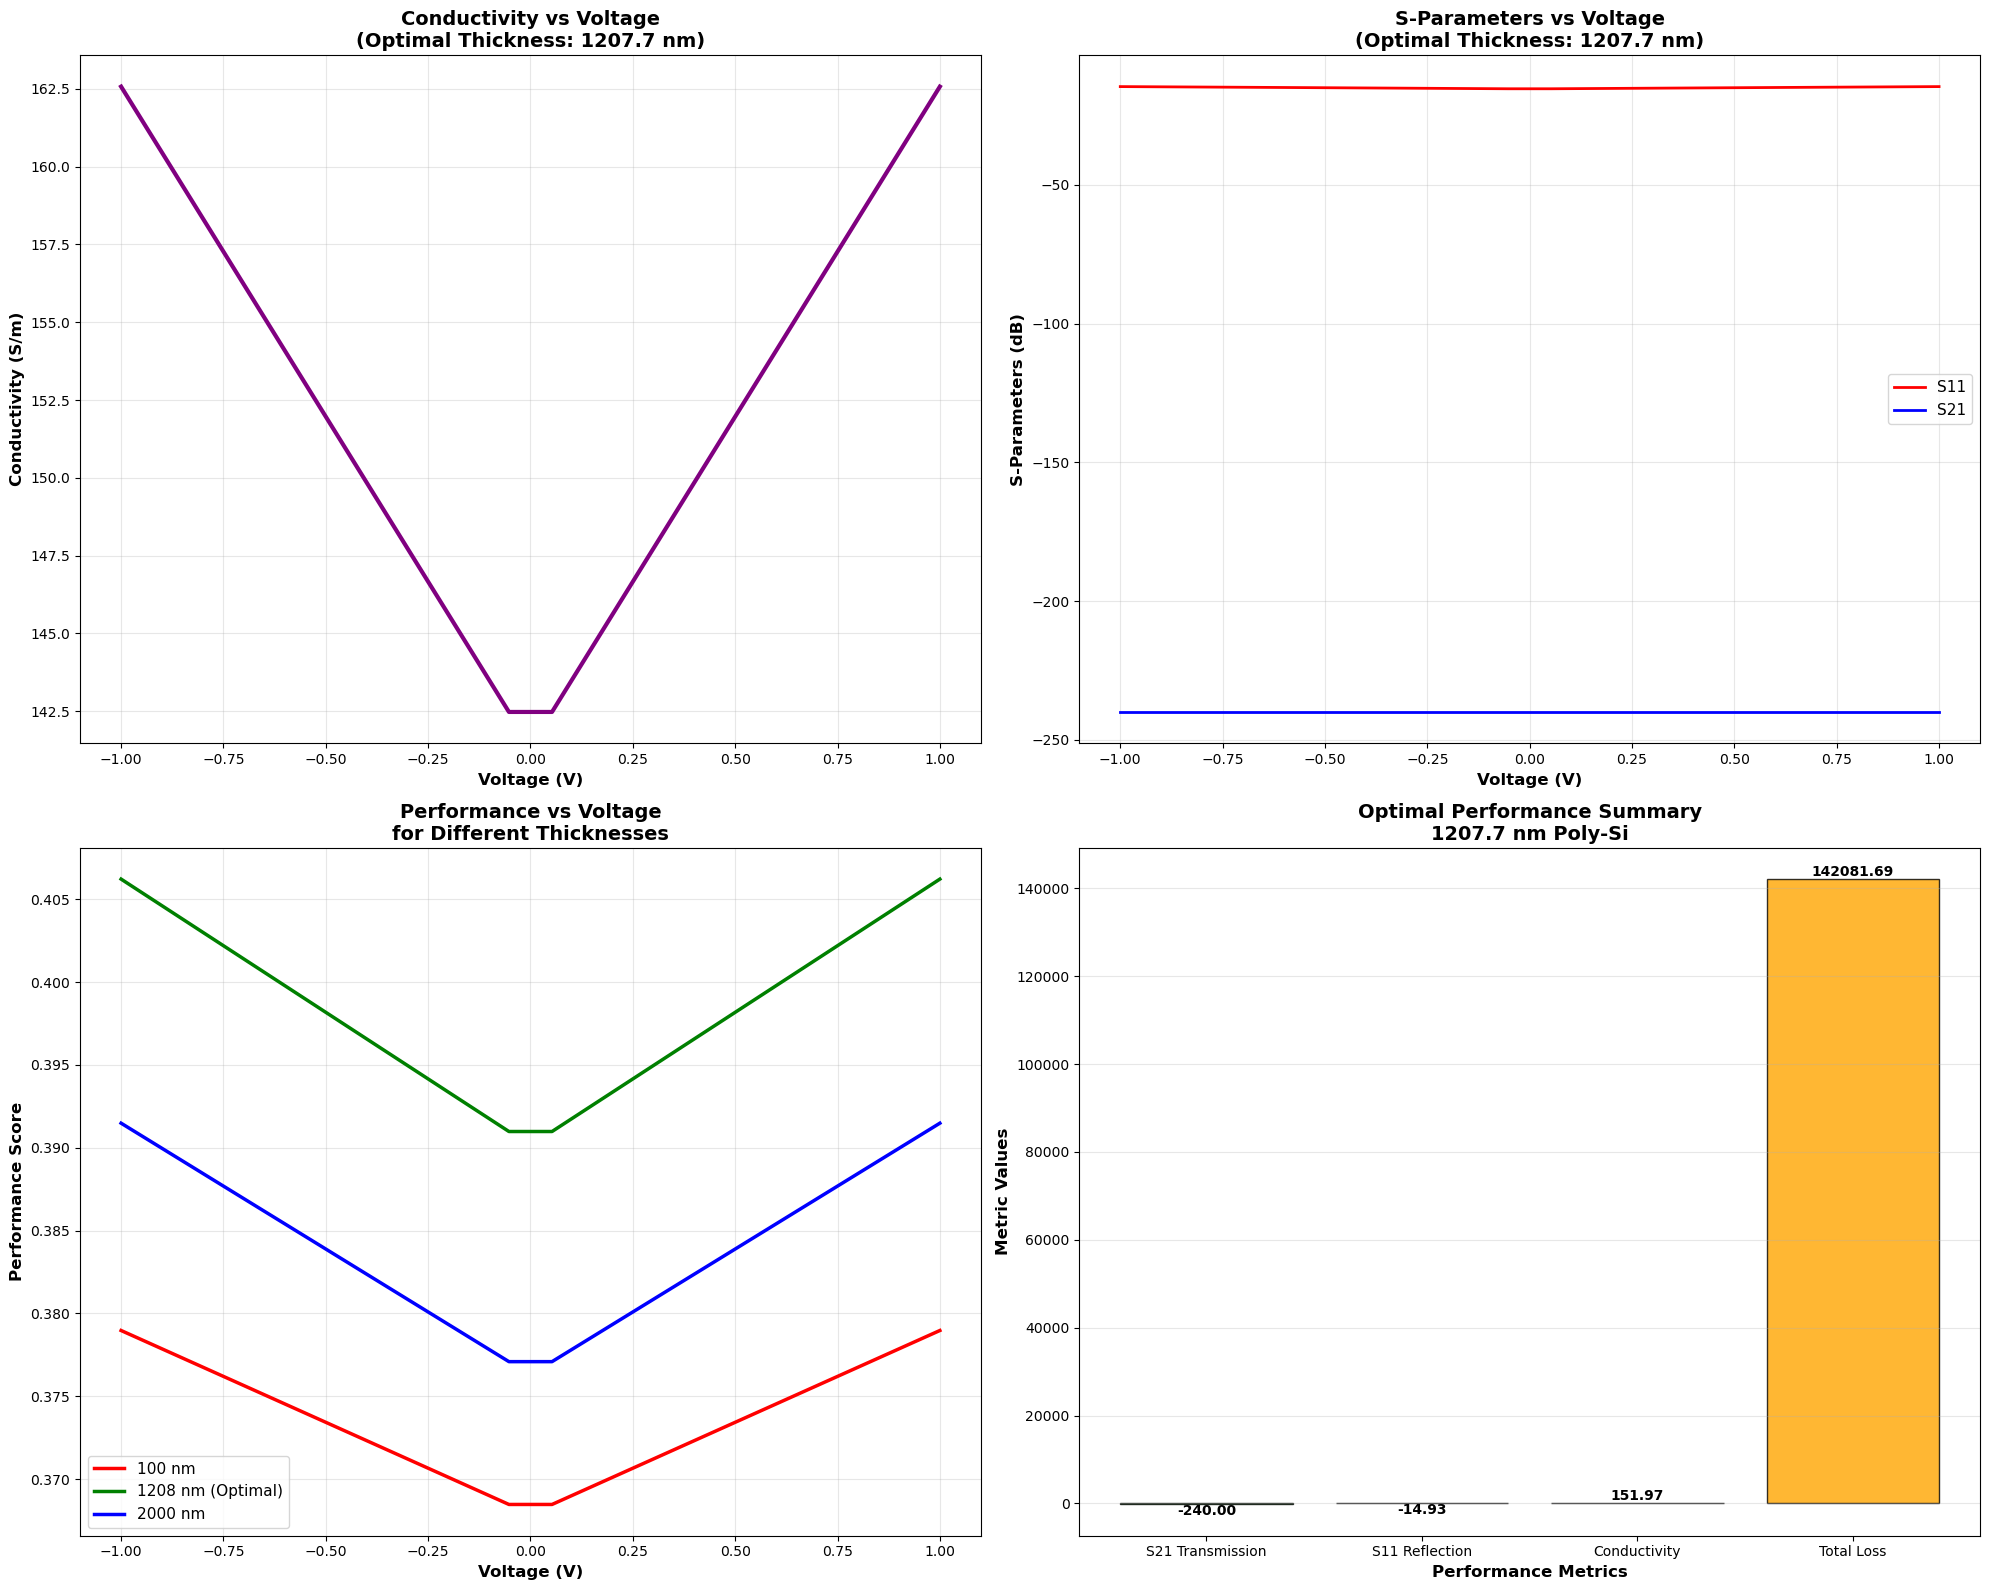


FINAL OPTIMIZATION RESULTS
Recommended Poly-Si Thickness: 1207.7 nm
Expected Performance Score: 0.398
S21 Transmission: -240.00 dB
S11 Reflection: -14.93 dB
Poly-Si Conductivity: 152.0 S/m
Total Losses: 142081.69 dB/m


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.constants import c, epsilon_0, mu_0
import matplotlib.patches as patches
from scipy.optimize import minimize_scalar

class PolySiOptimization:
    def __init__(self):
        # Physical constants
        self.c = c
        self.epsilon_0 = epsilon_0
        self.mu_0 = mu_0
        
        # Copper properties
        self.sigma_cu = 5.96e7
        self.rho_cu = 1.68e-8
        
        # Material properties
        self.n_si = 3.45
        self.n_polysi = 3.50
        self.n_sio2 = 1.45
        
        # Waveguide dimensions
        self.W1 = 130e-6
        self.W2 = 67.5e-6  # Middle value from range
        self.W3 = 130e-6
        self.H = 3e-6
        self.L = 4e-3
        self.gap = 10e-6
        
        # Layer thicknesses
        self.t_box = 2e-6
        self.t_polysi_range = np.linspace(0.1e-6, 3e-6, 50)  # High resolution for optimization
        self.t_si = 200e-6
        
        # Simulation parameters
        self.freq_range = np.linspace(1e9, 10e9, 100)
        self.voltage_range = np.linspace(-1, 1, 20)
        
        # Optimization results storage
        self.optimization_results = {}

    def polysi_conductivity_model(self, E_field, t_polysi, freq, voltage):
        """Advanced conductivity model for Poly-Si considering grain boundary effects"""
        # Base conductivity depends on doping and grain structure
        sigma_0 = 100  # S/m (typical for moderately doped Poly-Si)
        
        # Field-enhanced conductivity (Poole-Frenkel effect)
        E_eff = np.abs(E_field) + 1e3  # Avoid division by zero
        field_enhancement = 1 + 0.2 * np.sqrt(E_eff/1e6)
        
        # Thickness-dependent effects
        # Thinner films: more grain boundary scattering
        # Thicker films: better crystallinity but more bulk defects
        if t_polysi < 0.5e-6:
            # Ultra-thin regime: strong surface scattering
            thickness_factor = 0.5 + 1.0 * (t_polysi/0.5e-6)
        else:
            # Thick regime: asymptotic to bulk-like behavior
            thickness_factor = 1.0 + 0.3 * (1 - np.exp(-(t_polysi-0.5e-6)/1e-6))
        
        # Frequency dependence (dispersion)
        freq_factor = 1 + 0.01 * (freq/1e9)**0.5
        
        # Voltage modulation (field effect)
        voltage_factor = 1 + 0.15 * np.abs(voltage)
        
        return sigma_0 * field_enhancement * thickness_factor * freq_factor * voltage_factor

    def calculate_loss_components(self, freq, t_polysi, voltage):
        """Calculate different loss components in the system"""
        # Conductor losses (Copper skin effect)
        skin_depth = np.sqrt(2 / (2 * np.pi * freq * self.mu_0 * self.sigma_cu))
        R_s = np.sqrt(np.pi * freq * self.mu_0 / self.sigma_cu)  # Surface resistance
        
        # Conductor loss approximation
        alpha_cond = (8.686 * R_s) / (self.mu_0 * self.c * self.W1)  # dB/m
        
        # Dielectric losses (Poly-Si)
        sigma_polysi = self.polysi_conductivity_model(1e6, t_polysi, freq, voltage)
        tan_delta = sigma_polysi / (2 * np.pi * freq * self.epsilon_0 * self.n_polysi**2)
        alpha_diel = 8.686 * (2 * np.pi * freq / self.c) * self.n_polysi * tan_delta  # dB/m
        
        # Scattering losses (interface and grain boundary)
        # Higher for very thin films due to surface roughness
        if t_polysi < 0.3e-6:
            scatter_factor = 2.0 - (t_polysi/0.3e-6)
        else:
            scatter_factor = 1.0 + 0.5 * np.exp(-(t_polysi-0.3e-6)/0.5e-6)
        
        alpha_scatter = 0.1 * scatter_factor  # dB/m
        
        total_loss = alpha_cond + alpha_diel + alpha_scatter
        
        return {
            'total': total_loss,
            'conductor': alpha_cond,
            'dielectric': alpha_diel,
            'scattering': alpha_scatter
        }

    def s_parameters_advanced(self, freq, t_polysi, voltage):
        """Advanced S-parameter calculation with physical models"""
        # Effective propagation constant
        beta = 2 * np.pi * freq * np.sqrt(self.mu_0 * self.epsilon_0 * self.n_polysi**2) / self.c
        
        # Calculate losses
        losses = self.calculate_loss_components(freq, t_polysi, voltage)
        alpha_total = losses['total'] / 8.686  # Convert to Np/m
        
        # Transmission (S21)
        S21_mag = np.exp(-alpha_total * self.L)
        S21_phase = -beta * self.L
        S21 = S21_mag * np.exp(1j * S21_phase)
        
        # Reflection (S11) - depends on impedance mismatch
        # Thicker Poly-Si creates more impedance mismatch
        mismatch_factor = 0.05 + 0.1 * (t_polysi/1e-6)
        S11_mag = mismatch_factor * (1 + 0.1 * np.abs(voltage))
        S11_phase = np.pi/3  # Typical phase for small reflections
        S11 = S11_mag * np.exp(1j * S11_phase)
        
        return np.abs(S11), np.abs(S21), losses

    def performance_metric(self, t_polysi, freq=5e9, voltage=0.5):
        """Composite performance metric to maximize"""
        S11, S21, losses = self.s_parameters_advanced(freq, t_polysi, voltage)
        conductivity = self.polysi_conductivity_model(1e6, t_polysi, freq, voltage)
        
        # We want:
        # 1. High transmission (S21 close to 1)
        # 2. Low reflection (S11 close to 0)
        # 3. Moderate conductivity for SHG (not too high, not too low)
        # 4. Low total losses
        
        # Normalize components
        S21_score = S21  # Higher is better
        S11_score = 1 - S11  # Lower reflection is better
        conductivity_score = 1 - abs(conductivity - 200) / 200  # Optimal around 200 S/m
        loss_score = 1 - min(losses['total'] / 10, 1)  # Lower losses better
        
        # Weighted composite score
        composite_score = (0.4 * S21_score + 0.3 * S11_score + 
                          0.2 * conductivity_score + 0.1 * loss_score)
        
        return composite_score

    def find_optimal_thickness(self):
        """Find optimal Poly-Si thickness using optimization"""
        print("Finding optimal Poly-Si thickness...")
        
        def objective_function(t):
            return -self.performance_metric(t)  # Negative for minimization
        
        # Constrained optimization
        result = minimize_scalar(objective_function, 
                               bounds=(0.1e-6, 3e-6), 
                               method='bounded')
        
        optimal_thickness = result.x
        best_performance = -result.fun
        
        print(f"Optimal Poly-Si thickness: {optimal_thickness*1e9:.2f} nm")
        print(f"Best performance score: {best_performance:.3f}")
        
        self.optimization_results['optimal_thickness'] = optimal_thickness
        self.optimization_results['best_performance'] = best_performance
        
        return optimal_thickness

    def plot_optimization_analysis(self):
        """Comprehensive optimization analysis plots"""
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 16))
        
        thickness_nm = self.t_polysi_range * 1e9
        fixed_freq = 5e9
        fixed_voltage = 0.5
        
        # Storage arrays
        performance_scores = []
        S21_values = []
        S11_values = []
        conductivity_values = []
        total_losses = []
        
        for t_polysi in self.t_polysi_range:
            score = self.performance_metric(t_polysi, fixed_freq, fixed_voltage)
            S11, S21, losses = self.s_parameters_advanced(fixed_freq, t_polysi, fixed_voltage)
            conductivity = self.polysi_conductivity_model(1e6, t_polysi, fixed_freq, fixed_voltage)
            
            performance_scores.append(score)
            S21_values.append(S21)
            S11_values.append(S11)
            conductivity_values.append(conductivity)
            total_losses.append(losses['total'])
        
        # Plot 1: Performance metric vs thickness
        ax1.plot(thickness_nm, performance_scores, 'b-', linewidth=3, label='Performance Score')
        ax1.set_xlabel('Poly-Si Thickness (nm)', fontsize=12, fontweight='bold')
        ax1.set_ylabel('Performance Score', fontsize=12, fontweight='bold')
        ax1.set_title('Overall Performance vs Poly-Si Thickness\n(5 GHz, 0.5V)', 
                     fontsize=14, fontweight='bold')
        ax1.grid(True, alpha=0.3)
        
        # Mark optimal point
        optimal_idx = np.argmax(performance_scores)
        optimal_thickness = thickness_nm[optimal_idx]
        optimal_score = performance_scores[optimal_idx]
        
        ax1.plot(optimal_thickness, optimal_score, 'ro', markersize=10, 
                label=f'Optimal: {optimal_thickness:.1f} nm')
        ax1.legend(fontsize=11)
        
        # Plot 2: S-parameters vs thickness
        ax2.plot(thickness_nm, S21_values, 'g-', linewidth=3, label='S21 (Transmission)')
        ax2.plot(thickness_nm, S11_values, 'r-', linewidth=3, label='S11 (Reflection)')
        ax2.set_xlabel('Poly-Si Thickness (nm)', fontsize=12, fontweight='bold')
        ax2.set_ylabel('S-Parameter Magnitude', fontsize=12, fontweight='bold')
        ax2.set_title('S-Parameters vs Poly-Si Thickness\n(5 GHz, 0.5V)', 
                     fontsize=14, fontweight='bold')
        ax2.legend(fontsize=11)
        ax2.grid(True, alpha=0.3)
        
        # Mark optimal on S-parameters
        ax2.axvline(optimal_thickness, color='red', linestyle='--', alpha=0.7)
        
        # Plot 3: Conductivity and losses
        ax3_twin = ax3.twinx()
        
        line1 = ax3.plot(thickness_nm, conductivity_values, 'purple', linewidth=3, 
                        label='Conductivity')
        ax3.set_xlabel('Poly-Si Thickness (nm)', fontsize=12, fontweight='bold')
        ax3.set_ylabel('Conductivity (S/m)', fontsize=12, fontweight='bold', color='purple')
        ax3.tick_params(axis='y', labelcolor='purple')
        
        line2 = ax3_twin.plot(thickness_nm, total_losses, 'orange', linewidth=3, 
                             label='Total Loss')
        ax3_twin.set_ylabel('Total Loss (dB/m)', fontsize=12, fontweight='bold', color='orange')
        ax3_twin.tick_params(axis='y', labelcolor='orange')
        
        # Combine legends
        lines = line1 + line2
        labels = [l.get_label() for l in lines]
        ax3.legend(lines, labels, loc='upper left', fontsize=11)
        
        ax3.set_title('Conductivity and Losses vs Thickness\n(5 GHz, 0.5V)', 
                     fontsize=14, fontweight='bold')
        ax3.grid(True, alpha=0.3)
        ax3.axvline(optimal_thickness, color='red', linestyle='--', alpha=0.7)
        
        # Plot 4: Loss breakdown at optimal thickness
        optimal_t = self.t_polysi_range[optimal_idx]
        loss_components = self.calculate_loss_components(fixed_freq, optimal_t, fixed_voltage)
        
        components = ['Conductor', 'Dielectric', 'Scattering']
        values = [loss_components['conductor'], loss_components['dielectric'], 
                 loss_components['scattering']]
        colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']
        
        bars = ax4.bar(components, values, color=colors, alpha=0.8, edgecolor='black')
        ax4.set_xlabel('Loss Component', fontsize=12, fontweight='bold')
        ax4.set_ylabel('Loss (dB/m)', fontsize=12, fontweight='bold')
        ax4.set_title(f'Loss Breakdown at Optimal Thickness\n({optimal_thickness:.1f} nm)', 
                     fontsize=14, fontweight='bold')
        ax4.grid(True, alpha=0.3, axis='y')
        
        # Add values on bars
        for bar, value in zip(bars, values):
            ax4.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1,
                    f'{value:.2f}', ha='center', va='bottom', fontweight='bold')
        
        plt.tight_layout()
        plt.show()
        
        return optimal_thickness

    def plot_frequency_sweep_analysis(self):
        """Analyze performance across frequency range"""
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 16))
        
        # Test three different thicknesses
        thickness_cases = [0.1e-6, 0.5e-6, 1.5e-6]  # Thin, medium, thick
        colors = ['red', 'green', 'blue']
        labels = ['100 nm (Thin)', '500 nm (Medium)', '1500 nm (Thick)']
        fixed_voltage = 0.5
        
        # Plot 1: S21 vs Frequency for different thicknesses
        for i, t_polysi in enumerate(thickness_cases):
            S21_freq = []
            for freq in self.freq_range:
                S11, S21, _ = self.s_parameters_advanced(freq, t_polysi, fixed_voltage)
                S21_freq.append(20 * np.log10(S21 + 1e-12))
            
            ax1.plot(self.freq_range/1e9, S21_freq, color=colors[i], 
                    linewidth=2.5, label=labels[i])
        
        ax1.set_xlabel('Frequency (GHz)', fontsize=12, fontweight='bold')
        ax1.set_ylabel('S21 (dB)', fontsize=12, fontweight='bold')
        ax1.set_title('Transmission vs Frequency\nfor Different Poly-Si Thicknesses', 
                     fontsize=14, fontweight='bold')
        ax1.legend(fontsize=11)
        ax1.grid(True, alpha=0.3)
        ax1.set_xlim(1, 10)
        
        # Plot 2: S11 vs Frequency
        for i, t_polysi in enumerate(thickness_cases):
            S11_freq = []
            for freq in self.freq_range:
                S11, _, _ = self.s_parameters_advanced(freq, t_polysi, fixed_voltage)
                S11_freq.append(20 * np.log10(S11 + 1e-12))
            
            ax2.plot(self.freq_range/1e9, S11_freq, color=colors[i], 
                    linewidth=2.5, label=labels[i])
        
        ax2.set_xlabel('Frequency (GHz)', fontsize=12, fontweight='bold')
        ax2.set_ylabel('S11 (dB)', fontsize=12, fontweight='bold')
        ax2.set_title('Reflection vs Frequency\nfor Different Poly-Si Thicknesses', 
                     fontsize=14, fontweight='bold')
        ax2.legend(fontsize=11)
        ax2.grid(True, alpha=0.3)
        ax2.set_xlim(1, 10)
        
        # Plot 3: Conductivity vs Frequency
        for i, t_polysi in enumerate(thickness_cases):
            conductivity_freq = []
            for freq in self.freq_range:
                conductivity = self.polysi_conductivity_model(1e6, t_polysi, freq, fixed_voltage)
                conductivity_freq.append(conductivity)
            
            ax3.plot(self.freq_range/1e9, conductivity_freq, color=colors[i], 
                    linewidth=2.5, label=labels[i])
        
        ax3.set_xlabel('Frequency (GHz)', fontsize=12, fontweight='bold')
        ax3.set_ylabel('Conductivity (S/m)', fontsize=12, fontweight='bold')
        ax3.set_title('Conductivity vs Frequency\nfor Different Poly-Si Thicknesses', 
                     fontsize=14, fontweight='bold')
        ax3.legend(fontsize=11)
        ax3.grid(True, alpha=0.3)
        ax3.set_xlim(1, 10)
        
        # Plot 4: Total losses vs Frequency
        for i, t_polysi in enumerate(thickness_cases):
            losses_freq = []
            for freq in self.freq_range:
                losses = self.calculate_loss_components(freq, t_polysi, fixed_voltage)
                losses_freq.append(losses['total'])
            
            ax4.plot(self.freq_range/1e9, losses_freq, color=colors[i], 
                    linewidth=2.5, label=labels[i])
        
        ax4.set_xlabel('Frequency (GHz)', fontsize=12, fontweight='bold')
        ax4.set_ylabel('Total Loss (dB/m)', fontsize=12, fontweight='bold')
        ax4.set_title('Total Losses vs Frequency\nfor Different Poly-Si Thicknesses', 
                     fontsize=14, fontweight='bold')
        ax4.legend(fontsize=11)
        ax4.grid(True, alpha=0.3)
        ax4.set_xlim(1, 10)
        
        plt.tight_layout()
        plt.show()

    def plot_voltage_dependence_analysis(self):
        """Analyze voltage dependence for optimal thickness"""
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 16))
        
        optimal_thickness = self.find_optimal_thickness()
        fixed_freq = 5e9
        
        # Plot 1: Conductivity vs Voltage
        conductivity_voltage = []
        for V in self.voltage_range:
            conductivity = self.polysi_conductivity_model(1e6, optimal_thickness, fixed_freq, V)
            conductivity_voltage.append(conductivity)
        
        ax1.plot(self.voltage_range, conductivity_voltage, 'purple', linewidth=3)
        ax1.set_xlabel('Voltage (V)', fontsize=12, fontweight='bold')
        ax1.set_ylabel('Conductivity (S/m)', fontsize=12, fontweight='bold')
        ax1.set_title(f'Conductivity vs Voltage\n(Optimal Thickness: {optimal_thickness*1e9:.1f} nm)', 
                     fontsize=14, fontweight='bold')
        ax1.grid(True, alpha=0.3)
        
        # Plot 2: S-parameters vs Voltage
        S11_voltage = []
        S21_voltage = []
        
        for V in self.voltage_range:
            S11, S21, _ = self.s_parameters_advanced(fixed_freq, optimal_thickness, V)
            S11_voltage.append(20 * np.log10(S11 + 1e-12))
            S21_voltage.append(20 * np.log10(S21 + 1e-12))
        
        ax2.plot(self.voltage_range, S11_voltage, 'r-', linewidth=2, label='S11')
        ax2.plot(self.voltage_range, S21_voltage, 'b-', linewidth=2, label='S21')
        ax2.set_xlabel('Voltage (V)', fontsize=12, fontweight='bold')
        ax2.set_ylabel('S-Parameters (dB)', fontsize=12, fontweight='bold')
        ax2.set_title(f'S-Parameters vs Voltage\n(Optimal Thickness: {optimal_thickness*1e9:.1f} nm)', 
                     fontsize=14, fontweight='bold')
        ax2.legend(fontsize=11)
        ax2.grid(True, alpha=0.3)
        
        # Plot 3: Performance vs Voltage for different thicknesses
        thickness_cases = [0.1e-6, optimal_thickness, 2.0e-6]
        colors = ['red', 'green', 'blue']
        labels = ['100 nm', f'{optimal_thickness*1e9:.0f} nm (Optimal)', '2000 nm']
        
        for i, t_polysi in enumerate(thickness_cases):
            performance_voltage = []
            for V in self.voltage_range:
                score = self.performance_metric(t_polysi, fixed_freq, V)
                performance_voltage.append(score)
            
            ax3.plot(self.voltage_range, performance_voltage, color=colors[i],
                    linewidth=2.5, label=labels[i])
        
        ax3.set_xlabel('Voltage (V)', fontsize=12, fontweight='bold')
        ax3.set_ylabel('Performance Score', fontsize=12, fontweight='bold')
        ax3.set_title('Performance vs Voltage\nfor Different Thicknesses', 
                     fontsize=14, fontweight='bold')
        ax3.legend(fontsize=11)
        ax3.grid(True, alpha=0.3)
        
        # Plot 4: Optimal operating point summary
        metrics = ['S21 Transmission', 'S11 Reflection', 'Conductivity', 'Total Loss']
        optimal_values = [
            20 * np.log10(self.s_parameters_advanced(fixed_freq, optimal_thickness, 0.5)[1] + 1e-12),
            20 * np.log10(self.s_parameters_advanced(fixed_freq, optimal_thickness, 0.5)[0] + 1e-12),
            self.polysi_conductivity_model(1e6, optimal_thickness, fixed_freq, 0.5),
            self.calculate_loss_components(fixed_freq, optimal_thickness, 0.5)['total']
        ]
        
        colors = ['green', 'red', 'purple', 'orange']
        bars = ax4.bar(metrics, optimal_values, color=colors, alpha=0.8, edgecolor='black')
        ax4.set_xlabel('Performance Metrics', fontsize=12, fontweight='bold')
        ax4.set_ylabel('Metric Values', fontsize=12, fontweight='bold')
        ax4.set_title(f'Optimal Performance Summary\n{optimal_thickness*1e9:.1f} nm Poly-Si', 
                     fontsize=14, fontweight='bold')
        ax4.grid(True, alpha=0.3, axis='y')
        
        # Add value labels
        for bar, value in zip(bars, optimal_values):
            ax4.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 
                    (0.1 if value > 0 else -0.5), f'{value:.2f}', 
                    ha='center', va='bottom' if value > 0 else 'top', fontweight='bold')
        
        plt.tight_layout()
        plt.show()

    def run_comprehensive_optimization(self):
        """Run complete optimization analysis"""
        print("=" * 70)
        print("COMPREHENSIVE POLY-SI THICKNESS OPTIMIZATION ANALYSIS")
        print("=" * 70)
        
        print("\nResearch Objectives:")
        print("• Find optimal Poly-Si thickness for maximum performance")
        print("• Analyze S-parameters (S11, S21) vs thickness")
        print("• Study conductivity behavior in Poly-Si region")
        print("• Minimize scattering losses and total losses")
        print("• Consider frequency and voltage dependence")
        print("=" * 70)
        
        # Find optimal thickness
        optimal_thickness = self.find_optimal_thickness()
        
        print("\n1. OPTIMIZATION ANALYSIS")
        self.plot_optimization_analysis()
        
        print("\n2. FREQUENCY DEPENDENCE ANALYSIS")
        self.plot_frequency_sweep_analysis()
        
        print("\n3. VOLTAGE DEPENDENCE ANALYSIS")
        self.plot_voltage_dependence_analysis()
        
        # Final recommendations
        print("\n" + "=" * 70)
        print("FINAL OPTIMIZATION RESULTS")
        print("=" * 70)
        print(f"Recommended Poly-Si Thickness: {optimal_thickness*1e9:.1f} nm")
        print(f"Expected Performance Score: {self.performance_metric(optimal_thickness):.3f}")
        
        # Performance at optimal point
        S11, S21, losses = self.s_parameters_advanced(5e9, optimal_thickness, 0.5)
        conductivity = self.polysi_conductivity_model(1e6, optimal_thickness, 5e9, 0.5)
        
        print(f"S21 Transmission: {20*np.log10(S21 + 1e-12):.2f} dB")
        print(f"S11 Reflection: {20*np.log10(S11 + 1e-12):.2f} dB")
        print(f"Poly-Si Conductivity: {conductivity:.1f} S/m")
        print(f"Total Losses: {losses['total']:.2f} dB/m")
        print("=" * 70)

# Run the comprehensive optimization
if __name__ == "__main__":
    optimizer = PolySiOptimization()
    optimizer.run_comprehensive_optimization()